# Support Vector Machines

For this TP we will study the svm classifier to understand the effect of differents hyperparameters

We will first import different packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.metrics import RocCurveDisplay

## Dataset

For this first experience we will generate a two classes dataset drawned from two normal distribution usign the random genrator's `standard_normal()` method. It takes the shape of the samples to generate as argument.

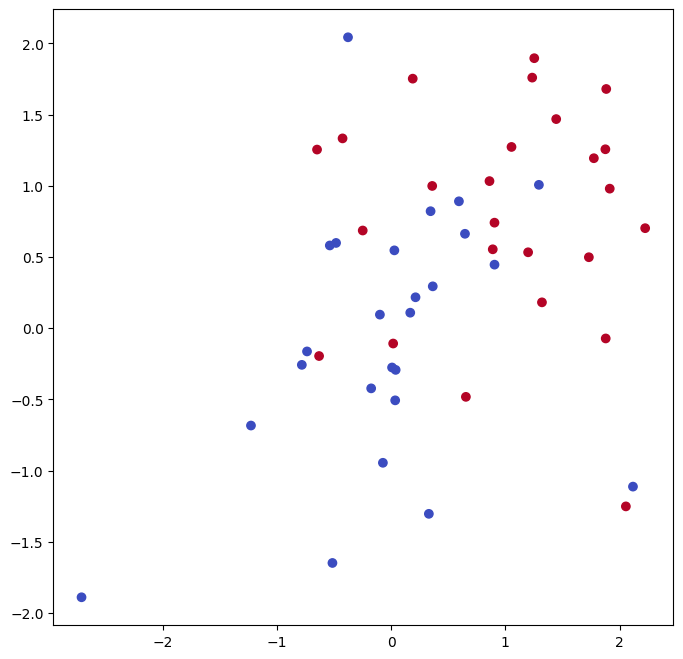

In [3]:
# we will use a random generator
generator = np.random.default_rng(1)
# let create x as a set of 50 2d sample drawn for a normal distribution
x = generator.standard_normal((50, 2))
# modify the last 25 samples to shift there mean to [1,1]
x[25:] += [1, 1]
# let create the labels y to be 0 for the first25 and 1 for the rest.
y = np.zeros(50)
y[25:] = 1

fig, ax = plt.subplots(figsize=(8,8))
scatter = ax.scatter(x[:,0],
           x[:,1],
           c=y,
           cmap=cm.coolwarm);

## Ploting function

Before starting we will create a small function to plat the decision boundary of an SVM classifier.
We will use the `DecisionBoundaryDisplay.from_estimator()` method. This code comes from sklearn documentation, but you can have a quick look to see what it does. `clf` will be our SVM classifier. Note that it will plot the boundary, the margin but also the support vectors.

In [4]:
from sklearn.inspection import DecisionBoundaryDisplay

def plot_training_data_with_decision_boundary(
    clf, _x, _y, ax=None, support_vectors=True, multiclass=False
):
    # Settings for plotting
    if ax is None:
        _, ax = plt.subplots(figsize=(8,8))

    # Plot decision boundary and margins
    common_params = {"estimator": clf, "X": _x, "ax": ax}
    DecisionBoundaryDisplay.from_estimator(
        **common_params,
        response_method="predict",
        plot_method="pcolormesh",
        alpha=0.3,
        cmap=cm.coolwarm
    )
    if not multiclass:
      DecisionBoundaryDisplay.from_estimator(
          **common_params,
          response_method="decision_function",
          plot_method="contour",
          levels=[-1, 0, 1],
          linestyles=["--", "-", "--"],
          cmap=cm.coolwarm
      )

    if support_vectors:
        # Plot bigger circles around samples that serve as support vectors
        ax.scatter(
            clf.support_vectors_[:, 0],
            clf.support_vectors_[:, 1],
            s=100,
            facecolors="none",
            edgecolors="k",
        )

    # Plot samples by color and add legend
    ax.scatter(_x[:, 0], _x[:, 1], c=_y, s=30, cmap=cm.coolwarm)

    if ax is None:
        plt.show()

### Support Vector Classifier

We now use the `SupportVectorClassifier()` function (abbreviated `SVC()`) from `sklearn` to fit the support vector classifier for a given value of the parameter `C` (the cost).  For recall, the cost `C` allows us to specify the cost of a violation to the margin.  When `C` is small, then the margins will be wide and many support vectors will be on the margin or will violate the margin.  When `C` is large, then the margins will be narrow and there will be few support vectors on the margin or violating the margin.


### Linear separation

The `kernel` parameter allows to choose the kernel used by our SVM model.
We can decide to stay in the orignal space we the `'linear'` kernel.

Train a SVM, with the `SVC()` object. Try first wit `C=10`

In [5]:
clf_linear = SVC(kernel='linear', C=10).fit(x, y)

Then plot it with our function

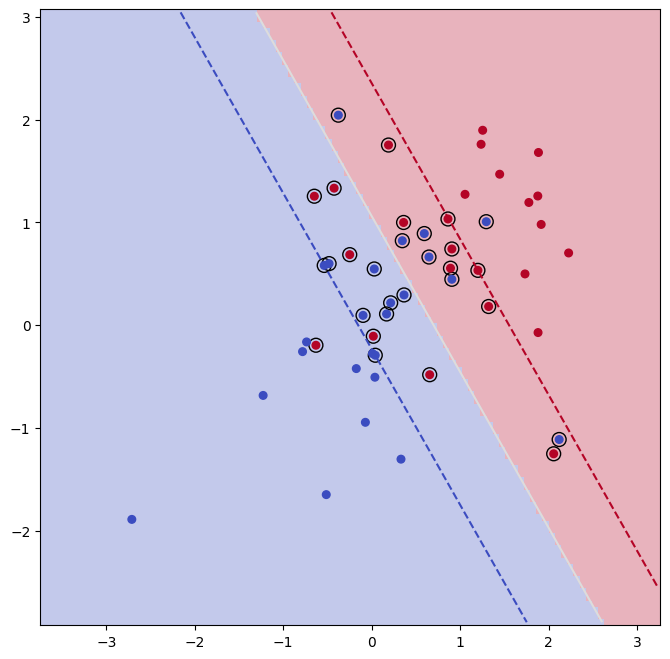

In [6]:
plot_training_data_with_decision_boundary(clf_linear, x, y)

Now change C to be lower, e.g. 0.1, and plot the new boundry

In [7]:
clf_linear = SVC(kernel='linear', C=0.1).fit(x, y)

With a smaller value of the cost parameter, we obtain a larger number of support vectors, because the margin is now wider. For linear kernels, we can extract the coefficients of the linear decision boundary as follows:

In [8]:
clf_linear.coef_


array([[0.71529828, 0.45433662]])

### Evaluation

Let's evalute our model by generetaing a test set with same procedure than previously

In [9]:
# Generate test set using same procedure
test_generator = np.random.default_rng(2)  # Different seed
x_test = test_generator.standard_normal((50, 2))
x_test[25:] += [1, 1]
y_test = np.zeros(50)
y_test[25:] = 1

Compare the performance of your two models by measuring there accuracy on the test set

In [10]:
from matplotlib.pyplot import cm
from sklearn.metrics import accuracy_score
# Model with C=10
clf_linear_10 = SVC(kernel='linear', C=10).fit(x, y)
# Model with C=0.1
clf_linear_01 = SVC(kernel='linear', C=0.1).fit(x, y)

# Compare accuracy
acc_10 = accuracy_score(y_test, clf_linear_10.predict(x_test))
acc_01 = accuracy_score(y_test, clf_linear_01.predict(x_test))

print(f"Accuracy with C=10: {acc_10:.4f}")
print(f"Accuracy with C=0.1: {acc_01:.4f}")


Accuracy with C=10: 0.8200
Accuracy with C=0.1: 0.7400


Now let's use our train set `(x,y)` to find the best value of `C`. To do so, we will use a grid search with a k-fold cross-validation, with k=5.
Have a look at `KFold` and `GridSearchCV` objects from svm. For `GridSearchCV` use the `cv` parmeter to link it with the `KFold`.

Try different values between 0.001 and 500, and use accuracy as evaluation metric.

In [12]:
from sklearn.model_selection import KFold, GridSearchCV
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 500]}
grid = GridSearchCV(
    SVC(kernel='linear'),
    param_grid,
    cv=kfold,
    scoring='accuracy'
)
grid.fit(x, y)
grid.best_params_

{'C': 1}

You can look at the trend of the accuracy with the following code

In [13]:
grid.cv_results_[('mean_test_score')]

array([0.46, 0.48, 0.72, 0.76, 0.76, 0.76, 0.76])

You can normy see that `C=1` results in the highest cross-validation (accuracy of 0.74), though the accuracy is the same for several values of `C`.


The classifier `grid.best_estimator_` can be used to predict the class labels. You can evaluate ir on our test set

In [14]:
test_acc = accuracy_score(y_test, grid.best_estimator_.predict(x_test))
print(f"Best C value: {grid.best_params_['C']}")
print(f"Test accuracy with best model: {test_acc:.4f}")

Best C value: 1
Test accuracy with best model: 0.7800


## Support vectors

Let's make our data more separable to study the selection of the support vectors.

To do taht let's shift our `y==1` data by `2` than plot it

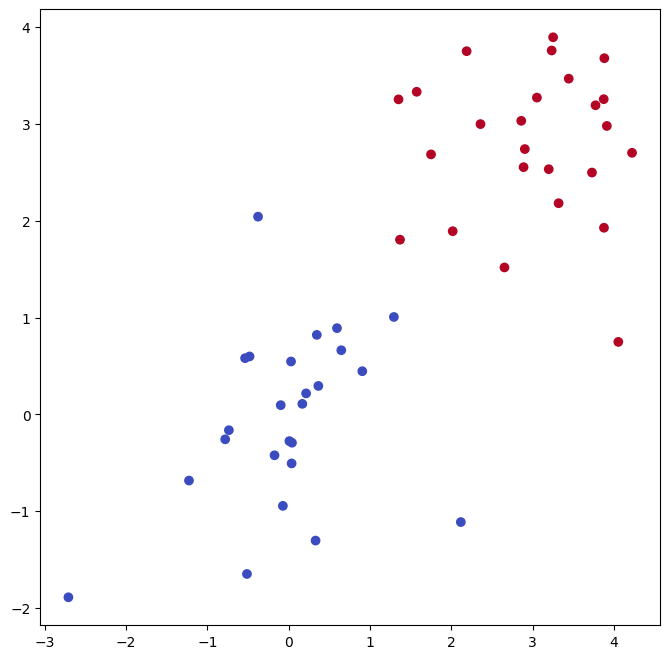

In [15]:
# Shift y==1 data by 2
x[y==1, :] += [2, 2]

fig, ax = plt.subplots(figsize=(8,8))
ax.scatter(x[:,0], x[:,1], c=y, cmap=cm.coolwarm);

Now the observations are just barely linearly

Fit a new svm classifier with `C=10` and compute the accuracy.

In [16]:
# edit here
svm = SVC(kernel='linear', C=10).fit(x, y)
accuracy = accuracy_score(y, svm.predict(x))
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 1.0000


Now plot the boundary and look at how many points are in the support vectors.

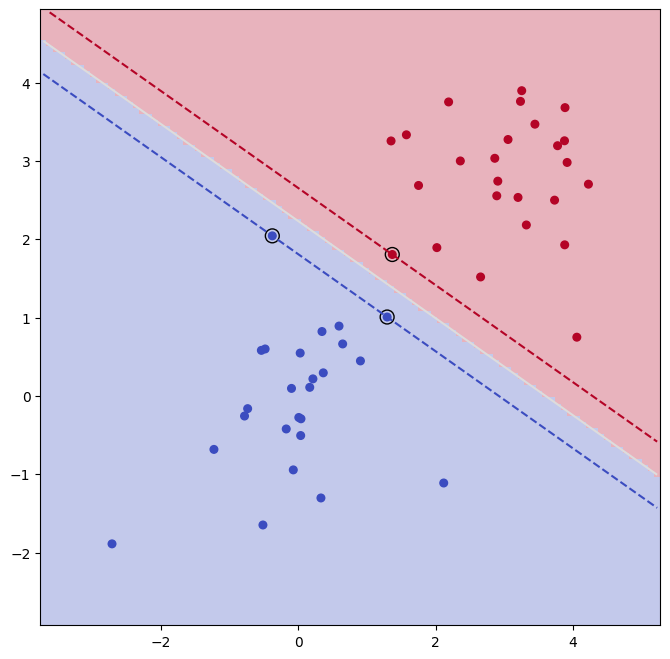

In [17]:
plot_training_data_with_decision_boundary(svm, x, y)

Remember that the decision boundary only depend on these (three) points !

You can enlarge the margin to make you model more robust, try with `C=0.1` for example.

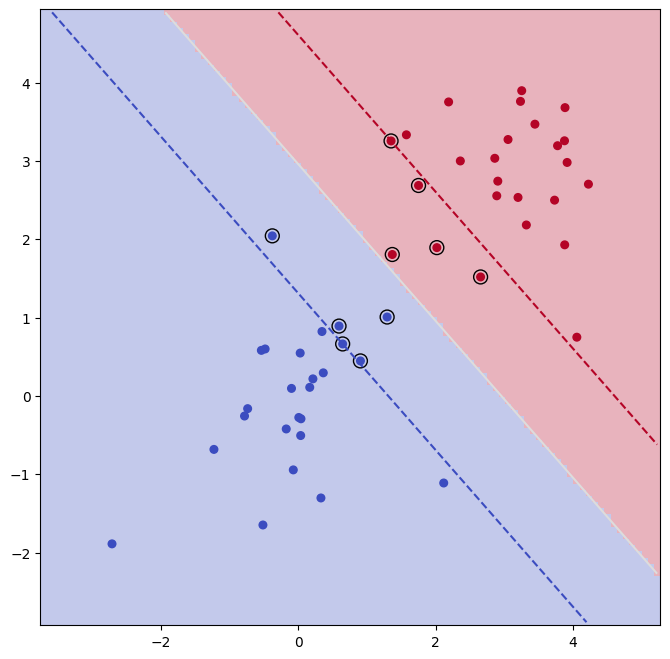

In [18]:
svm_01 = SVC(kernel='linear', C=0.1).fit(x, y)
plot_training_data_with_decision_boundary(svm_01, x, y)


## Non Linear boundries

In order to fit an SVM using a non-linear kernel, we once again use the `SVC()`  estimator. However, now we use a different value of the parameter `kernel`. To fit an SVM with a polynomial kernel we use `kernel="poly"`, and to fit an SVM with a radial kernel  we use `kernel="rbf"`.  In the former case we also use the `degree` argument to specify a degree for the polynomial kernel (this is $p$ in the slides), and in the latter case we use `gamma` to specify a value of $\gamma$ for the radial basis kernel ($\gamma =\frac{1}{2\sigma^2}$ in the slides).

We first generate some data with a non-linear class boundary. To do so generate 210 samples as follow:
the first 140 bellong to the first class and the

* 70 first to class 1 shifted to be centred on [2,2]
* 70 that follows to class 1 but shifted to be centred on [-2,-2]
* 70 last of class 2 remains centred on [0,0]

In [19]:
x = generator.standard_normal((210, 2))
# First 70 points class 1, centered at [2,2]
x[:70] += [2, 2]
# Next 70 points class 1, centered at [-2,-2]
x[70:140] += [-2, -2]
# Last 70 points class 2, centered at [0,0]
y = np.zeros(210)
y[:140] = 1  # First 140 points are class 1

Let's plot it

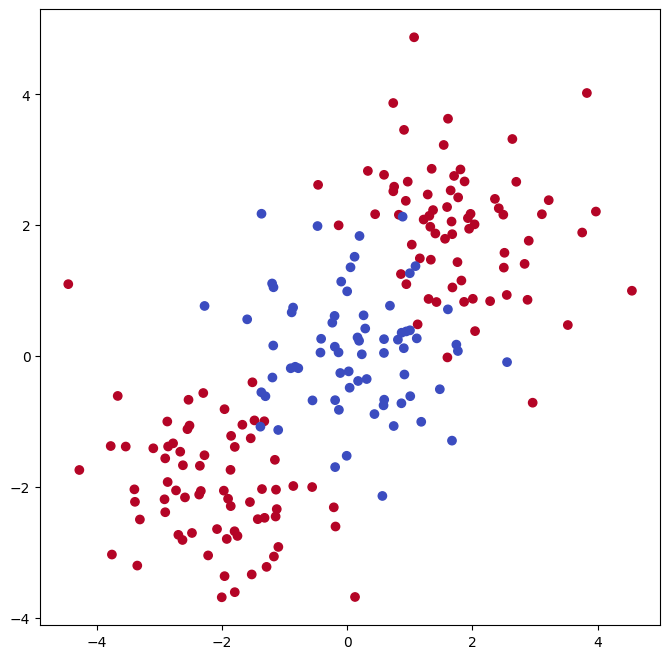

In [20]:
fig, ax = plt.subplots(figsize=(8,8))
ax.scatter(x[:,0],
           x[:,1],
           c=y,
           cmap=cm.coolwarm);

This time we will do a train/test split with `train_test_split`.

In [21]:
from sklearn.model_selection import train_test_split

(x_train, x_test, y_train, y_test) = train_test_split(
    x, y, test_size=0.3, random_state=42
)

Now fit a model with `"rbd"` kernel and plot the boundry `C=1` and `gamma = 1`

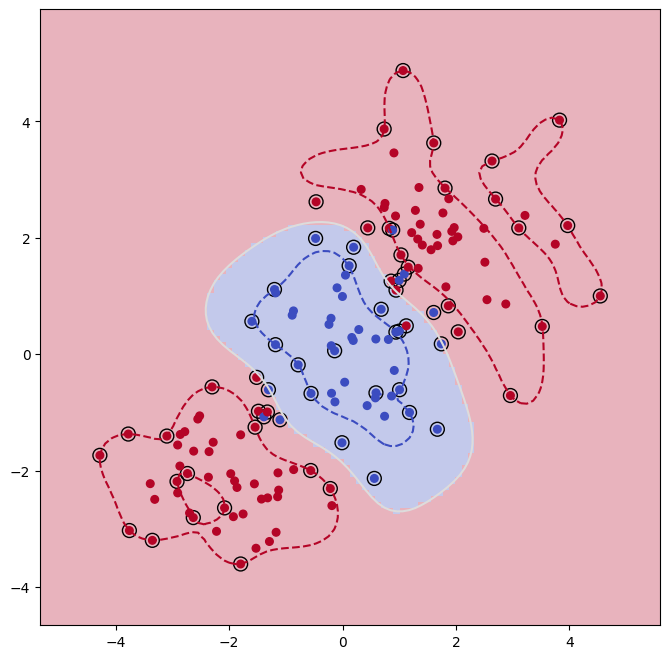

In [22]:
svm_rbf = SVC(kernel='rbf', C=1, gamma=1).fit(x_train, y_train)
plot_training_data_with_decision_boundary(svm_rbf, x_train, y_train)

We can see from the figure that there are a fair number of training errors in this SVM fit.  If we increase the value of `C`, we can reduce the number of training errors. However, this comes at the
price of a more irregular decision boundary that seems to be at risk of overfitting the data.

As previously, perform cross-validation using `GridSearchCV()`  to select the best choice of `gamma` and `C` for an SVM with a radial kernel.

Best parameters: {'C': 1, 'gamma': 0.1}


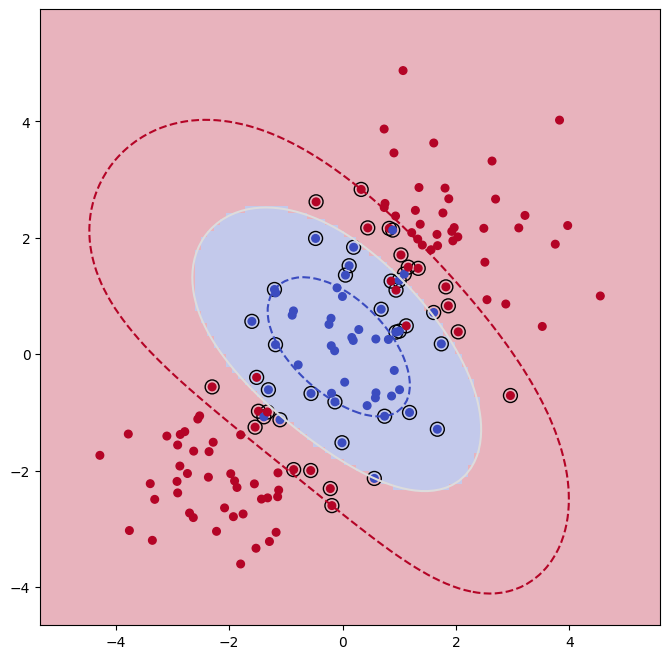

In [23]:
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [0.1, 1, 10, 'scale', 'auto']
}
grid = GridSearchCV(
    SVC(kernel='rbf'),
    param_grid,
    cv=5,
    scoring='accuracy'
)
grid.fit(x_train, y_train)
print(f"Best parameters: {grid.best_params_}")
best_rbf = grid.best_estimator_
plot_training_data_with_decision_boundary(best_rbf, x_train, y_train)

Now do the same with the polynomial kernel, you can try different values of `degree` and `coef0`.

Best parameters: {'C': 100, 'coef0': 0, 'degree': 4}


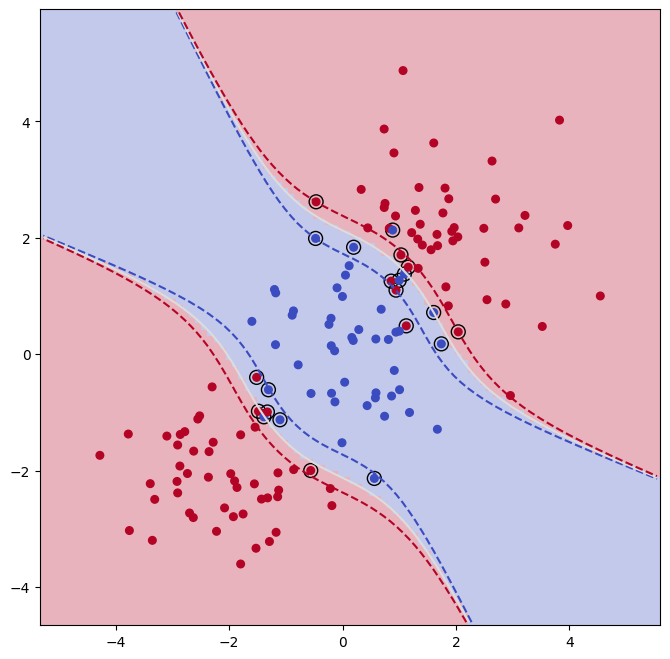

In [24]:
param_grid = {
    'C': [0.1, 1, 10, 100],
    'degree': [2, 3, 4],
    'coef0': [0, 1, 2]
}
grid = GridSearchCV(
    SVC(kernel='poly'),
    param_grid,
    cv=5,
    scoring='accuracy'
)
grid.fit(x_train, y_train)
print(f"Best parameters: {grid.best_params_}")
best_poly = grid.best_estimator_
plot_training_data_with_decision_boundary(best_poly, x_train, y_train)

## SVM with Multiple Classes

If the response is a factor containing more than two levels, then the `SVC()`  function will perform multi-class classification using
either the one-versus-one approach (when `decision_function_shape=='ovo'`)
or one-versus-all {One-versus-all is also known as one-versus-rest.} (when `decision_function_shape=='ovr'`).
We explore that setting briefly here by
generating a third class of observations.

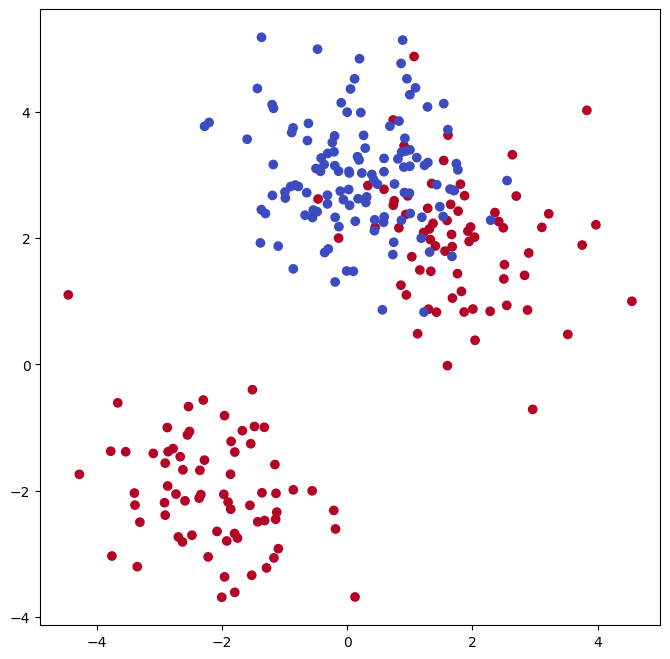

In [25]:
genrator2 = np.random.default_rng(123)
x = np.vstack([x, genrator2.standard_normal((50, 2))])
y = np.hstack([y, [0]*50])
x[y==0,1] += 3
fig, ax = plt.subplots(figsize=(8,8))
ax.scatter(x[:,0], x[:,1], c=y, cmap=cm.coolwarm);

We can now fit an SVM to the data, use the radial kernel.

Try both strategies and plot it. Note that you need to use `multiclass=True` for the `plot_training_data_with_decision_boundary()` method.

SVC(C=10, decision_function_shape='ovo', gamma=1)

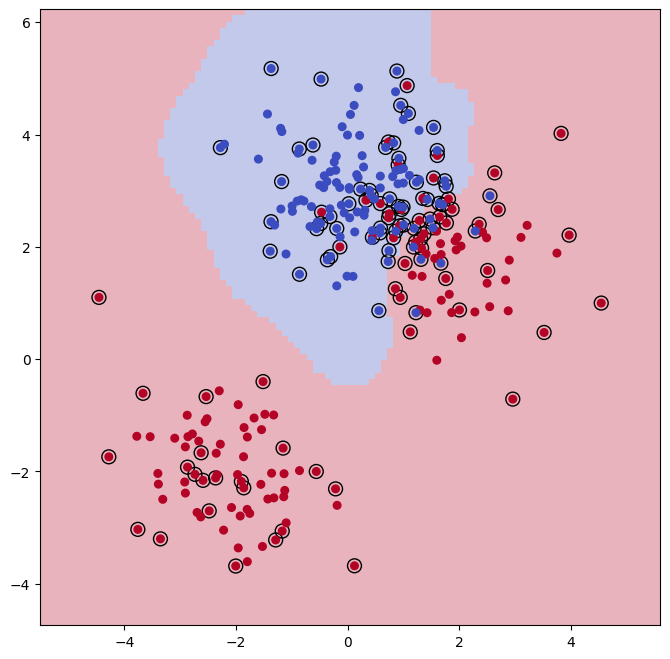

In [26]:
# train and plot with ovo
svm_rbf_ovo = SVC(kernel='rbf', C=10, gamma=1, decision_function_shape='ovo').fit(x, y)
plot_training_data_with_decision_boundary(svm_rbf_ovo, x, y, multiclass=True)
svm_rbf_ovo

SVC(C=10, gamma=1)

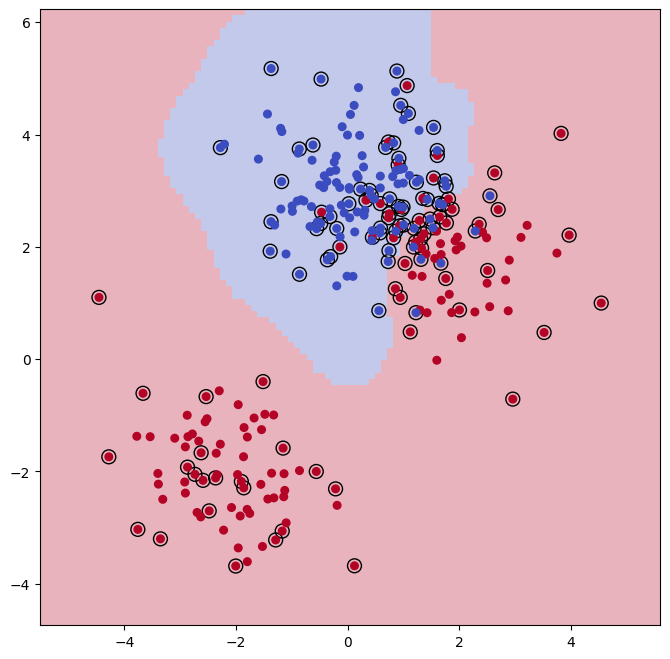

In [27]:
# train and plot with ovr
svm_rbf_ovr = SVC(kernel='rbf', C=10, gamma=1, decision_function_shape='ovr').fit(x, y)
plot_training_data_with_decision_boundary(svm_rbf_ovr, x, y, multiclass=True)
svm_rbf_ovr

You can notice that the two boundries are identical. This is often the case when the number of classes is small.